<div align='center'><img src="./images/blog_pictures.webp" height= "500" width="1100px"></div>

# Проект: Задача классификации

### Загрузка необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
import optuna


In [2]:
# зафиксируем версии пакетов
!pip freeze > requirements.txt

---

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

Загрузка датасета:

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


**Разделим данные на несколько групп и определим целевой признак**

Данные о клиентах банка:

* `age` (возраст);
* `job` (сфера занятости);
* `marital` (семейное положение);
* `education` (уровень образования);
* `default` (имеется ли просроченный кредит);
* `housing` (имеется ли кредит на жильё);
* `loan` (имеется ли кредит на личные нужды);
* `balance` (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* `contact` (тип контакта с клиентом);
* `month` (месяц, в котором был последний контакт);
* `day` (день, в который был последний контакт);
* `duration` (продолжительность контакта в секундах).

Прочие признаки:

* `campaign` (количество контактов с этим клиентом в течение текущей кампании);
* `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* `previous` (количество контактов до текущей кампании)
* `poutcome` (результат прошлой маркетинговой кампании).

Целевая переменная: `deposit` (определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать)

Проверим данные на пропуски, посмотрим в каких столбцах они есть, и сколько их:

In [5]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Видим, что в признаке `balance` 25 пропущенных значения, в остальных пропусков нет.      

### Задание 2

Узнаем есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом

In [6]:
# Посмотрим, какие вообще есть значения в этом признаке, и сколько их
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

70 записей с неизвестной сферой занятости.


### Задание 3

Нужно преобразовать признак `balance` таким образом, чтобы он корректно считывался, как вещественное число (float)

In [7]:
# с помощью метода apply и lambda-функции преобразуем признак, так как в этом столбце есть пропуски, зададим условие в lambda-функцию,
# если значение строка, то делаем преобразования методом replace, в противном случае оставляем как есть
df['balance'] = df['balance'].apply(lambda x: float(x.replace(' ', '').replace(',', '.').replace('$', '')) if type(x)==str else x)
df['balance'].head(2)

0    2343.0
1      45.0
Name: balance, dtype: float64

In [8]:
f"Среднее значение по преобразованному столбцу balance: {df['balance'].mean().round(3)}"

'Среднее значение по преобразованному столбцу balance: 1529.129'

### Задание 4

Заменим пропуски в признаки balance на медианные значения по данному признаку:

In [9]:
# С помощью метода fillna заменяем пропущенные значения на медианы данного признака
df['balance'] = df['balance'].fillna(df['balance'].median())
f"Cреднее значение по преобразованному в корректный вид признаку `balance`: {df['balance'].mean().round(3)}"

'Cреднее значение по преобразованному в корректный вид признаку `balance`: 1526.936'

In [10]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Проверяем наличие пропусков, их больше нет.

После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).

### Задание 5

Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде, а обозначены, как unknown. Однако нам всё равно важно их обработать. Заменим их на модальные значения этого признака:

In [11]:
# Вычислим моду признак заранее, чтобы каждый раз не вычислять ее внутри apply
job_mode = df['job'].mode()[0]
# Преобразеум столбец
df['job'] = df['job'].apply(lambda x: job_mode if x=='unknown' else x)

In [12]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

В признаке education тоже есть значения unknown, их так же преобразуем:


In [13]:
ed_mode = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: ed_mode if x=='unknown' else x)

После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).

In [14]:
# Отфильтруем данные, оставим только строки, где самая популярная работа и самое популярное образование
filtered_df = df[(df['job']==job_mode) & (df['education']==ed_mode)]
# Рассчитаем средний баланс в отфильтрованной таблтце
f"Cредний баланс для клиентов с самой популярной работой и самым популярным образованием: {filtered_df['balance'].mean().round(3)}"

'Cредний баланс для клиентов с самой популярной работой и самым популярным образованием: 1598.883'

### Задание 6

Удалим все выбросы из признака balance

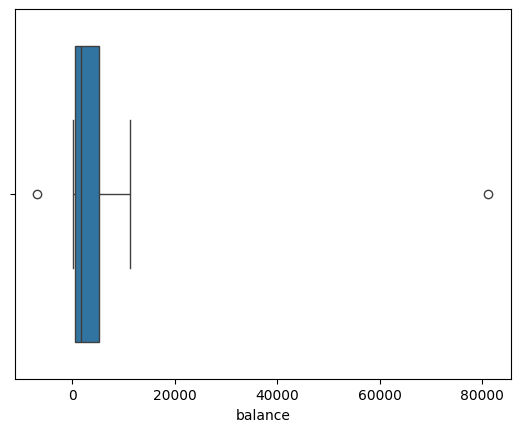

In [15]:
sns.boxplot(df['balance'].describe(), orient='h');

In [16]:
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

На ящике с усами видим два выброса, удалим их методом Тьюки:

In [17]:
# Найдем 1 и 3 квартили
quartile_1 = df['balance'].quantile(0.25)
quartile_3 = df['balance'].quantile(0.75)
# Считаем межквартильный размах
iqr = quartile_3 - quartile_1
# Посчитаем нижнюю и врхнюю границы, это будет полтора межквартильного размаха вправо и влево
lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

# Оставим в данных только те записи, которые входят в эту границу
df_tykey = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]


In [18]:
print(f"Верхняя граница по методу Тьюки: {upper_bound}")
print(f"Нижняя граница по методу Тьюки: {lower_bound}")

Верхняя граница по методу Тьюки: 4063.0
Нижняя граница по методу Тьюки: -2241.0


Посмотрим на описательную статистику после удаления выбросов

In [19]:
df_tykey['balance'].describe()

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

---

## Часть 2:  Разведывательный анализ

### Задание 1

Изучим соотношение классов в наших данных на предмет несбалансированности


In [20]:
f"{df_tykey['deposit'].value_counts(normalize=False)[1]} клиент открыл депозит"

'4681 клиент открыл депозит'

In [21]:
df_tykey['deposit'].value_counts(normalize=True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

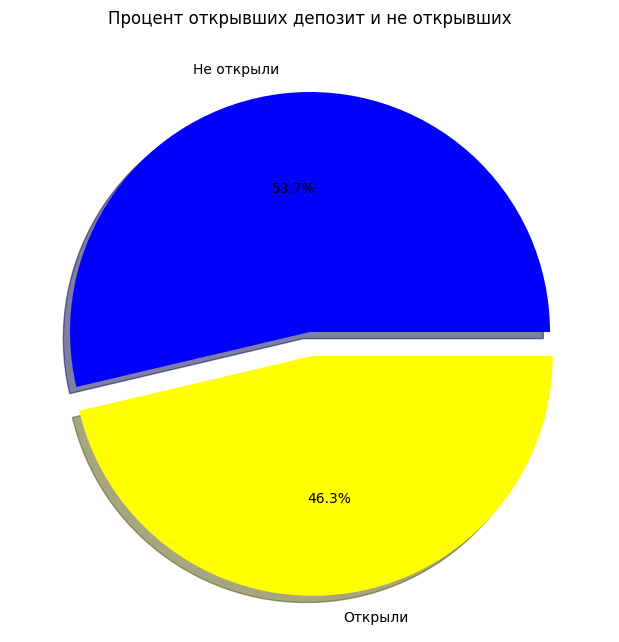

In [22]:
fig = plt.figure(figsize=(6,6))
axes = fig.add_axes([0,0,1,1])
axes.pie(df_tykey['deposit'].value_counts(),
         labels= ['Не открыли', 'Открыли'], # устанавливаем метки
         autopct = '%.1f%%', # Будем отображать доли в процентах и округлять их до одного знака после запятой
         colors = ['Blue', 'Yellow'], # устанавливаем жулаемые цвета
         explode = [0, 0.1], # второй сектор двигаем от центра на 10%
         shadow=True # Добавим тень
         )
axes.set_title('Процент открывших депозит и не открывших');

Видим, что наш целевой признак достаточно сбалансирован.

### Задания 2 и 3

Рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат

In [23]:
df_tykey.describe(include=[np.number])

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Среднее значение возраста 40.9 и небольшое стандартное отклонение 11.7, говорит о том, что большинство клиентов среднего возраста.
Высокое стандартное отклонение в балансе, указывает на сильную вариативность в признаке. В признаке day минимум 1, максимум 31, что соответствует дням в месяце, большинство контактов происходило в середине месяца. В признаке продолжительность контакта, среднее значение 368.7 секунд, это чуть больше 6 минут, типичная продолжительность, стандартоное отклонение указывает на существенный разброс в признаке, максимальное значение 3881 секунд или больше часа, возможно это ошибка в данных, нужно проверять данные на аномалии. Максимальное значение в признаке campaign - 43, большое количество контактов для отдельных клиентов может быть признаком навязчивого маркетинга или ошибки данных.
В pdays значение -1, вероятно, означает отсутствие контактов. В previous среднее значение 0.8, говорит о том, что большинство клиентов не контактировали, или контактировали 1 раз, а максимальное значение 58, может указывать на аномалию или на черезмерную навязчивость.

**Выводы по вариативности и аномалиям**

- Колонка balance имеет отрицательные значения, что указывает на клиентов с задолженностью.
- Колонки campaign и previous имеют значения до 43 и 58 контактов соответственно, что может указывать на потенциальные ошибки или избыточные контакты.
- Колонка duration также демонстрирует высокую вариативность, что может сигнализировать о некоторых аномальных значениях (например, звонки продолжительностью 2 секунды или более часа).

Визуализируем распределения:


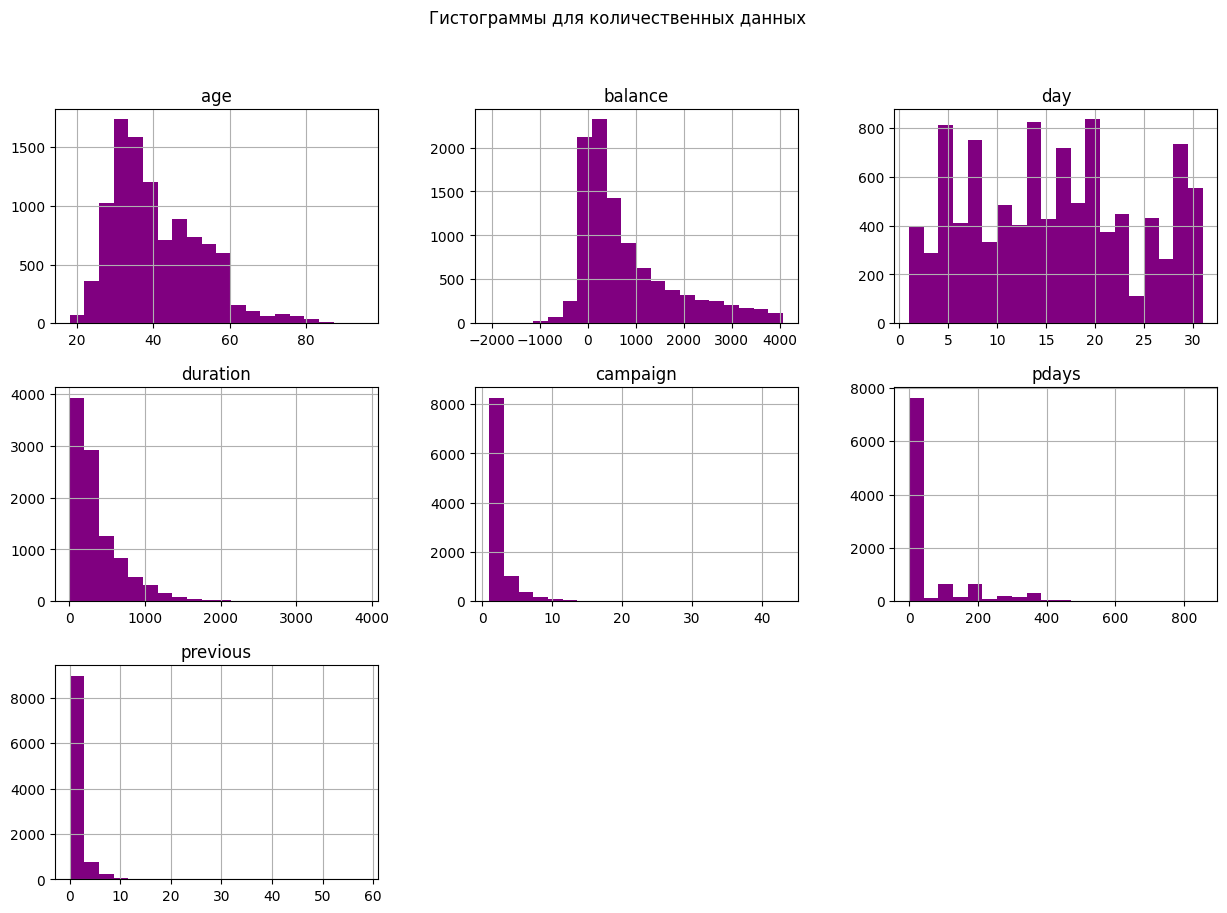

In [24]:
# Гистограммы для каждого числового столбца
df_tykey.hist(bins=20, figsize=(15, 10), color='purple')
plt.suptitle("Гистограммы для количественных данных")
plt.show()

### Задания 4 и 5

Рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат

In [25]:
df_tykey.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


**Интерпретация описательных статистик:**
1. `job` (работа):

    - Наиболее частое значение (top): management.
    - Частота (freq): 2315. Указывает, что из всех клиентов большинство занято в управленческой сфере.

2. `marital` (семейное положение):

    - Наиболее частое значение: married.
    - Частота: 5715. Большинство клиентов женаты.

3. `education` (уровень образования):

    - Наиболее частое значение: secondary.
    - Частота: 5517. Подавляющее большинство клиентов имеют среднее образование.

4. `default` (наличие дефолта):

    - Наиболее частое значение: no.
    - Частота: 9939. Практически все клиенты не имеют дефолта по кредитам.

5. `housing` (ипотека):

    - Наиболее частое значение: no.
    - Частота: 5243. Больше половины клиентов не имеют ипотечного кредита.

6. `loan` (потребительский кредит):

    - Наиболее частое значение: no.
    - Частота: 8712. У большинства клиентов нет потребительского кредита.

7. `contact` (способ связи):

    - Наиболее частое значение: cellular.
    - Частота: 7283. Наиболее предпочтительный способ связи — сотовая связь.

8. `month` (месяц обращения):

    - Наиболее частое значение: may.
    - Частота: 2617. Большинство обращений происходит в мае.

9. `poutcome` (результат предыдущей кампании):

    - Наиболее частое значение: unknown.
    - Частота: 7570. Для большинства клиентов результат предыдущей кампании неизвестен.

10. `deposit` (наличие вклада): Целевой признак

    - Наиболее частое значение: no.
    - Частота: 5424. Большинство клиентов не имеют активных вкладов.

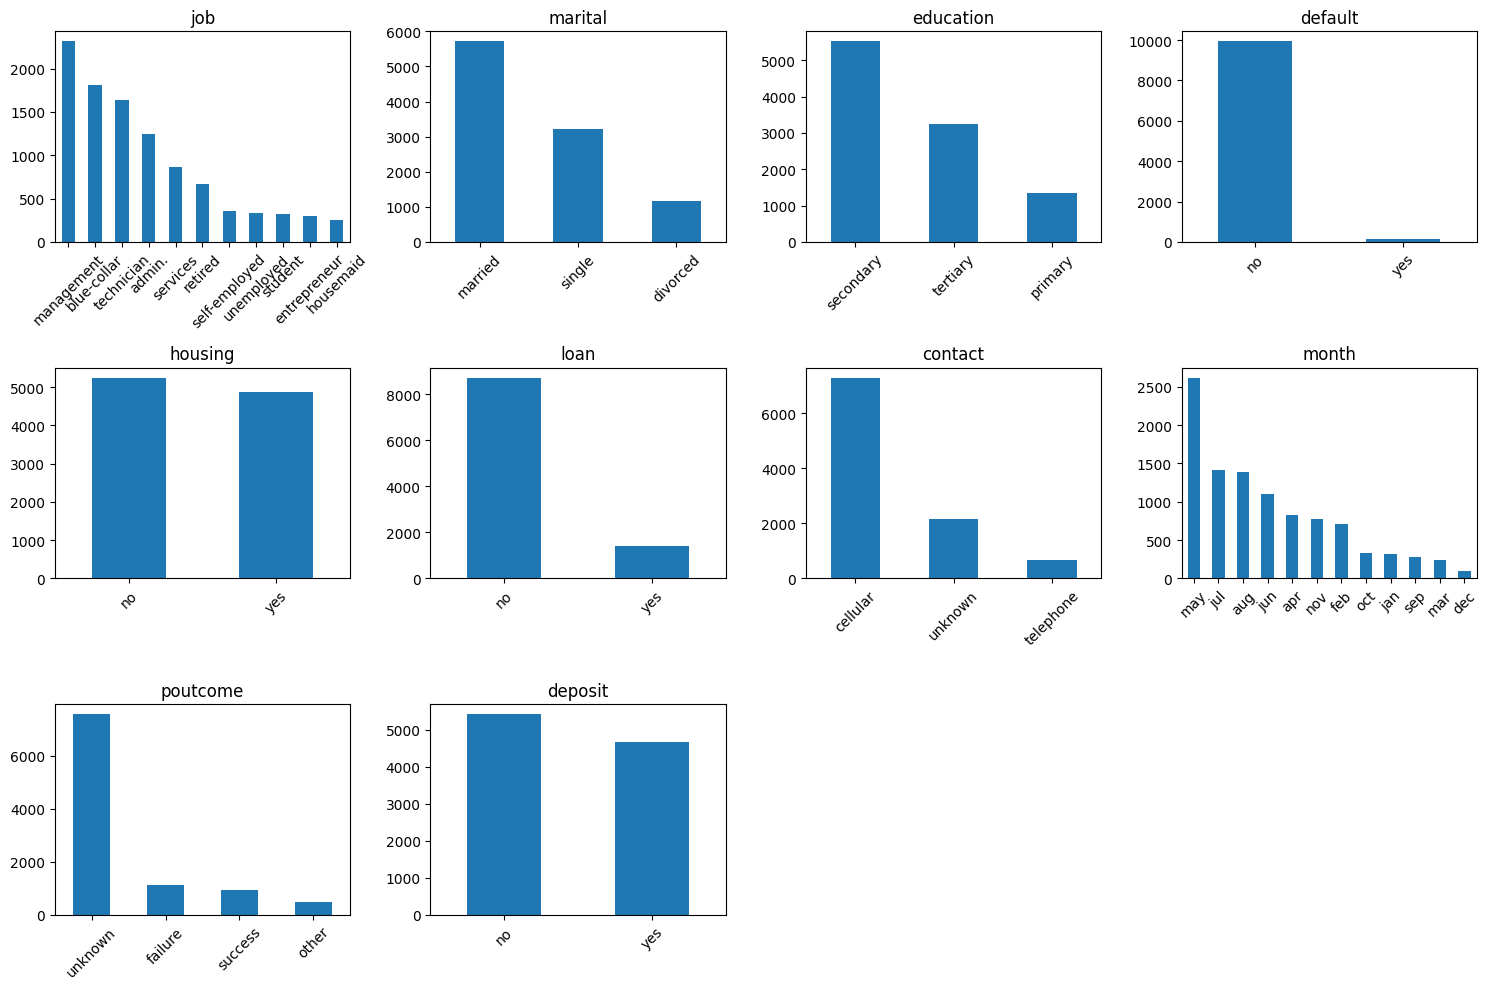

In [26]:
# сохраним в переменную все признаки типа object
cat_col = df_tykey.select_dtypes(include=[object]).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_col, 1):
    plt.subplot(3, 4, i)
    df_tykey[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

На этих графиках мы можем быстро оценить распределение категорий и частоту их встречаемости.

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 6

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [27]:
poutcome_df = df_tykey.groupby(['poutcome'])['deposit'].value_counts().unstack()
poutcome_df

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


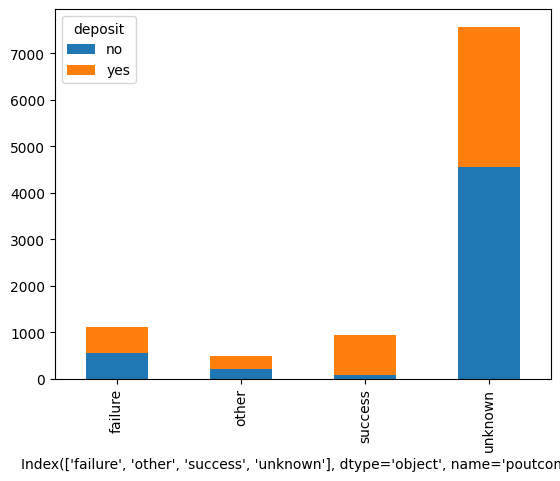

In [28]:
poutcome_df.plot(kind='bar', stacked='True')
plt.xlabel(poutcome_df.index)
plt.show()

Видим, что для статуса success, предыдущей кампании, успехов намного больше, чем неудач

Теперь узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.



### Задание 7

Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит

deposit,no,yes
month,,
apr,38.192771,61.807229
aug,55.956679,44.043321
dec,9.677419,90.322581
feb,45.557123,54.442877
jan,60.815047,39.184953
jul,58.956276,41.043724
jun,54.891304,45.108696
mar,10.126582,89.873418
may,67.863966,32.136034


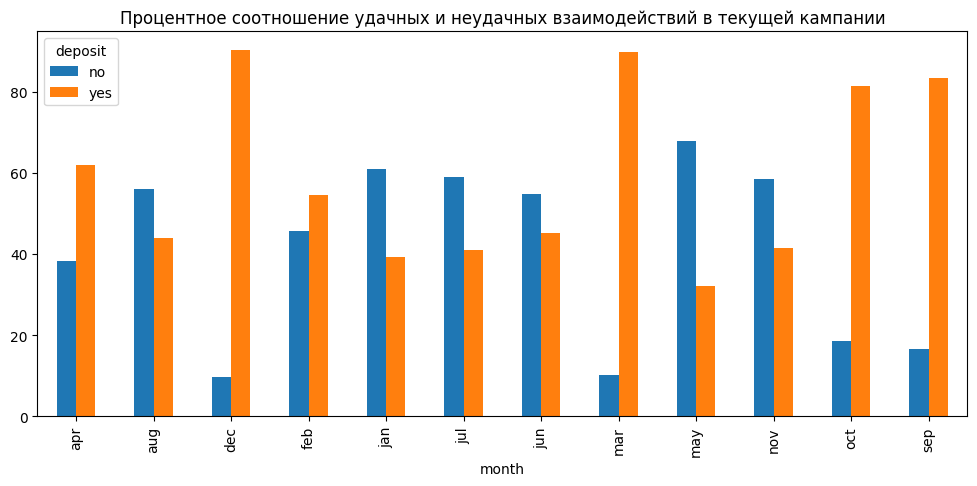

In [29]:
month_df = df_tykey.groupby(['month'])['deposit'].value_counts(normalize=True).unstack()*100
display(month_df)
month_df.plot(kind='bar', figsize=(12,5))
plt.title("Процентное соотношение удачных и неудачных взаимодействий в текущей кампании");

В мае самый большой процент неудач, почти 68% взаимодействий с клиантами, заканчивалось неудачей, а вот в декабре и марте 90% удачный контактов, при это общее количество взаимодействий самое большое в мае. Возможно, стоит большую активность проявлять не в мае, а в декабре и марте.

### Задание 8

Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения

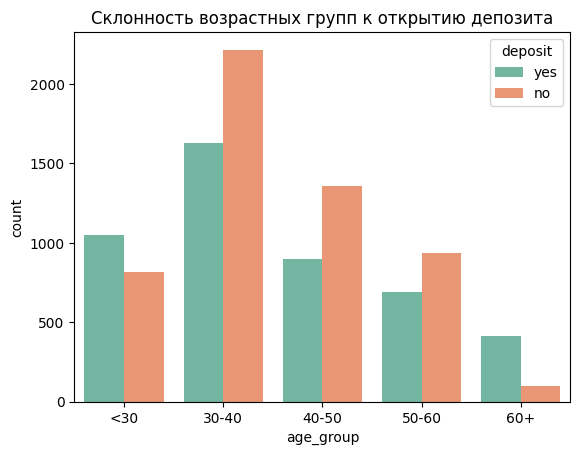

In [30]:
# Для создания категорий используем метод cut()
df_tykey['age_group'] = pd.cut(df_tykey.age, [0, 30, 40, 50, 60, 100], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(data=df_tykey, x='age_group', hue='deposit', palette='Set2')
plt.title("Склонность возрастных групп к открытию депозита")
plt.show()

Две группы более склонны открывать депозит, чем не открывать, это клиенты младше 30 и старше 60.

### Задания 9 и 10

Построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса:

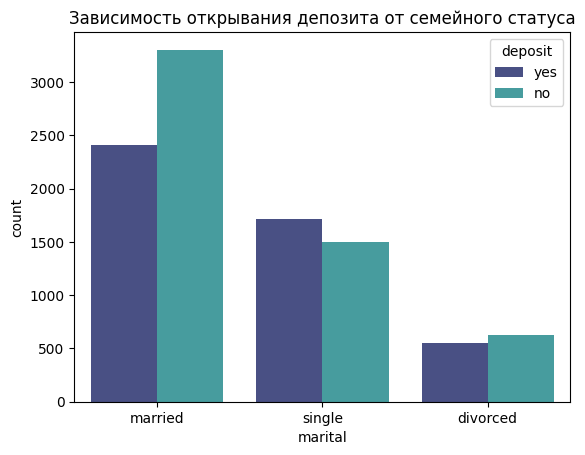

In [31]:
sns.countplot(data=df_tykey, x='marital', hue='deposit', palette='mako')
plt.title("Зависимость открывания депозита от семейного статуса")
plt.show()

Единственная категория, которая чаще открывает, чем не открывает, это одинокие.


Построим визуализацию для открывших и неоткрывших депозит в зависимости от образования:

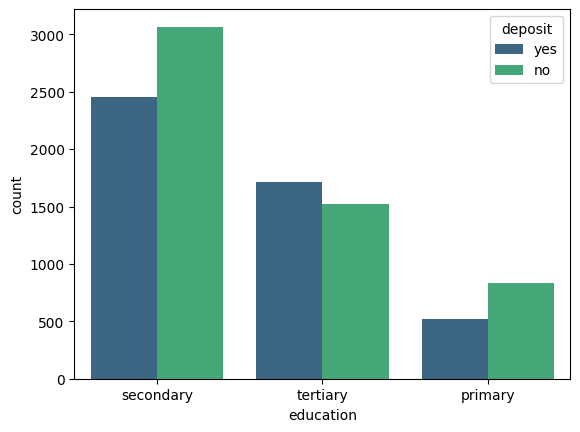

In [32]:
sns.countplot(data=df_tykey, x='education', hue='deposit', palette='viridis');

Чаще открывают, чем не открывают депозит, клиенты с высшим образованием.

Построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

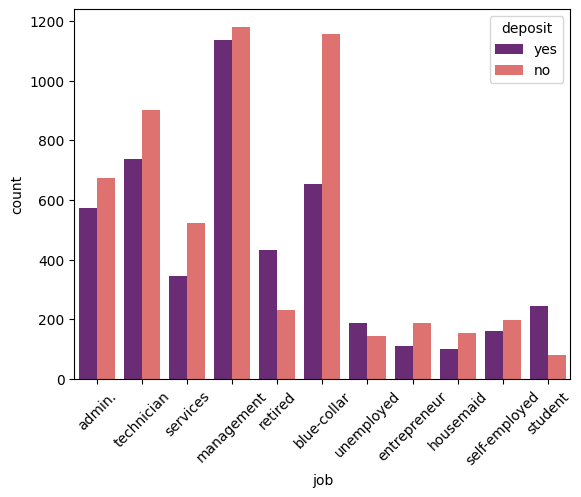

In [33]:
sns.countplot(data=df_tykey, x='job', hue='deposit', palette='magma')
plt.xticks(rotation=45);

Чаще открывают, чем не открывают студенты, безработные и клиенты на пенсии, возможно плохие условия для работающих людей, нужно подумать, как привлекать работающих, они для банка будут более выгодные клиенты.

В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?


### Задание 11

Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны (если рассматривать тех, кто открыл депозит)

In [34]:
# Отфильтруем данные, оставим только тех, кто открыл депозит
df_11_yes = df_tykey[df_tykey['deposit']=='yes']
# Сгруппируем по образованию и семейному положению
df_11_yes_counts = df_11_yes.groupby(['education', 'marital'])['deposit'].count().unstack()
df_11_yes_counts

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны (если рассматривать тех, кто не открыл депозит)

In [35]:
# Отфильтруем данные, оставим только тех, кто не открыл депозит
df_11_no = df_tykey[df_tykey['deposit']=='no']
# Сгруппируем по образованию и семейному положению
df_11_no_counts = df_11_no.groupby(['education', 'marital'])['deposit'].count().unstack()
df_11_no_counts

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


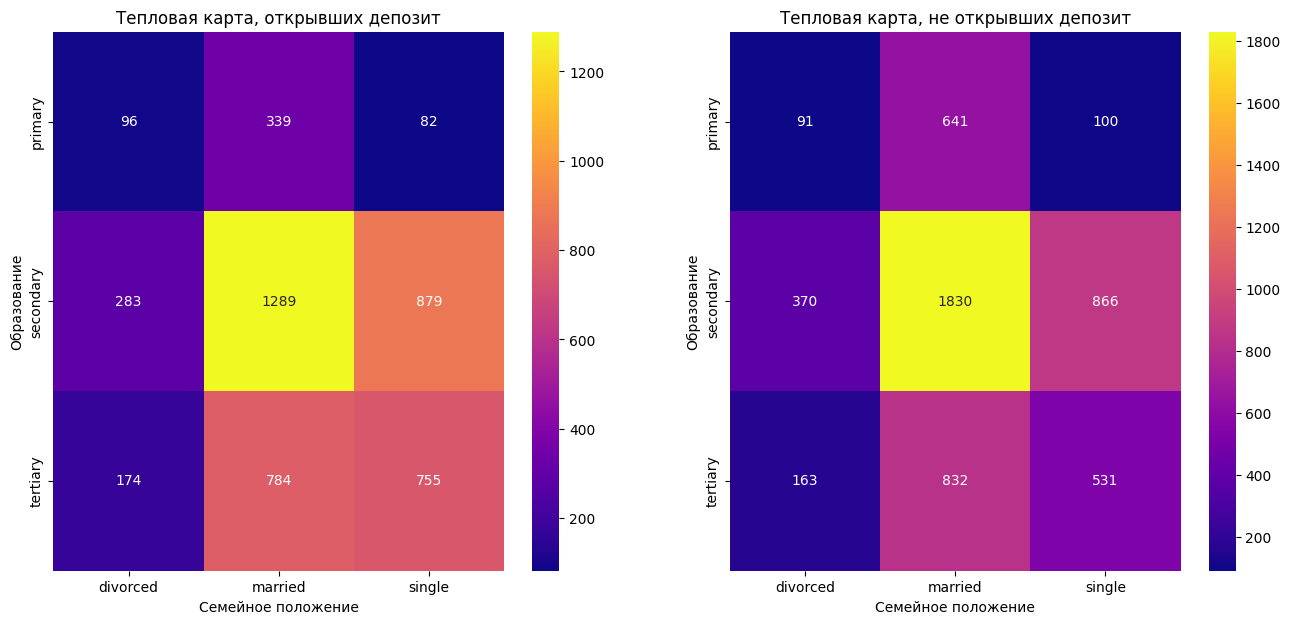

In [36]:
# строим тепловые карты
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
heatmap1 = sns.heatmap(df_11_yes_counts, annot=True, cmap="plasma", fmt='g', ax=axes[0])
heatmap1.set_title("Тепловая карта, открывших депозит")
heatmap1.set_xlabel("Семейное положение")
heatmap1.set_ylabel("Образование")

heatmap2 = sns.heatmap(df_11_no_counts, annot=True, cmap="plasma", fmt='g', ax=axes[1])
heatmap2.set_title("Тепловая карта, не открывших депозит")
heatmap2.set_xlabel("Семейное положение")
heatmap2.set_ylabel("Образование");

Среди клиентов, открывших депозит, больше всего женатых со средним образованием, среди не открывших, так же больше женатых со средним образованием.

Посмотрим, как признак "баланс" может быть связан с нашей целевой переменной

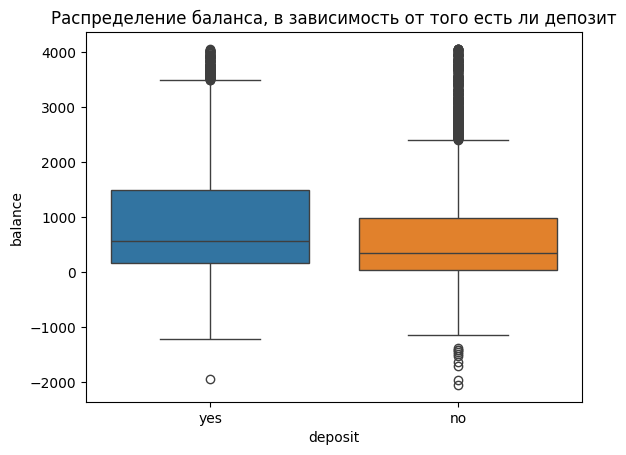

In [37]:
sns.boxplot(data=df_tykey, x='deposit', y='balance', hue='deposit')
plt.title("Распределение баланса, в зависимость от того есть ли депозит")
plt.show()

У тех клиентов, у которых есть депозит медианный баланс выше, чем у какго нет депозита, так же видим, что у клиентов с депозитом большая вариативность баланса.

Проверим с помощью статистического теста, есть ли статистически значимые различия в распределениях баланса клиентов с депозитом и без него.

Гипотезы:

* Нулевая гипотеза: распределения балансов клиентов с депозитом и без депозита одинаковы.
* Альтернативная гипотеза: баланс клиентов с депозитом выше чем у клиентов без депозита.

In [38]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# разделим баланс на группы
balance_yes = df_tykey[df_tykey['deposit']=='yes']['balance']
balance_no = df_tykey[df_tykey['deposit']=='no']['balance']

# проверим выборки на нормальность тестом Шапиро-Уилка
res = stats.shapiro(balance_yes)
p1 = res[1]
if p1 <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))
    
res2 = stats.shapiro(balance_yes)
p2 = res2[1]
if p2 <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))
    
    
# так как распределение у нас отлично от нормального, воспользуемся критерием Манна-Уитни
_, p = stats.mannwhitneyu(balance_yes, balance_no, alternative='greater')
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha)) 

p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Тест показал, что есть статистически значимый прирост в признаке "баланс" у клиентов с депозитом, по сравнению с клиентами без депозита.
Можно сделать вывод, что фактор "баланс" влияет на нашу целевую переменную.

---

## Часть 3: преобразование данных

### Задание 1

Преобразуем уровни образования

In [39]:
# Инициализируем кодировщик
encoder = LabelEncoder()

df_tykey['education'] = encoder.fit_transform(df_tykey['education'])
df_tykey['education'].sum()

11995

Преобразуем возраст так же, с помощью LabelEncoder

In [40]:
df_tykey['age_group'] = encoder.fit_transform(df_tykey['age_group'])

### Задания 2 и 3

Преобразуем бинарные переменные в представление из нулей и единиц

In [41]:
df_tykey['deposit'] = df_tykey['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df_tykey['deposit'].std()

0.4986712532452124

In [42]:
# воспользуемся кодировщиком LabelBinarizer
bin_encoder = LabelBinarizer()

df_tykey['default'] = bin_encoder.fit_transform(df_tykey['default'])
df_tykey['default'].value_counts()

0    9939
1     166
Name: default, dtype: int64

In [43]:
df_tykey['housing'] = bin_encoder.fit_transform(df_tykey['housing'])
df_tykey['housing'].value_counts()

0    5243
1    4862
Name: housing, dtype: int64

In [44]:
df_tykey['loan'] = bin_encoder.fit_transform(df_tykey['loan'])
df_tykey['loan'].value_counts()

0    8712
1    1393
Name: loan, dtype: int64

In [45]:
round(df_tykey['default'].mean() + df_tykey['housing'].mean() + df_tykey['loan'].mean(), 3)

0.635

### Задание 4

Cоздадим дамми-переменные

In [46]:
# признаки, которые будем кодировать
data = df_tykey[['job', 'marital', 'contact', 'month', 'poutcome']]

In [47]:
oh_encoder = OneHotEncoder(sparse_output=False) # sparse_output=False возвращает массив, а не разреженную матрицу

encoded_data = oh_encoder.fit_transform(data)

# Создаем DataFrame с именами столбцов
column_names = oh_encoder.get_feature_names_out(data.columns)
one_hot_df = pd.DataFrame(encoded_data, columns=column_names)

# объеденим с исходной таблицей, сбросили индексы в исходной таблице, чтобы они совпали при конкатенации
df_encoded = pd.concat([df_tykey.reset_index(drop=True), one_hot_df], axis=1)
df_encoded.head(2)


,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
df_encoded = df_encoded.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

### Задания 5 и 6

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

In [49]:
# Строим корреляционную матрицу
cor_matrix = df_encoded.corr(method='pearson')

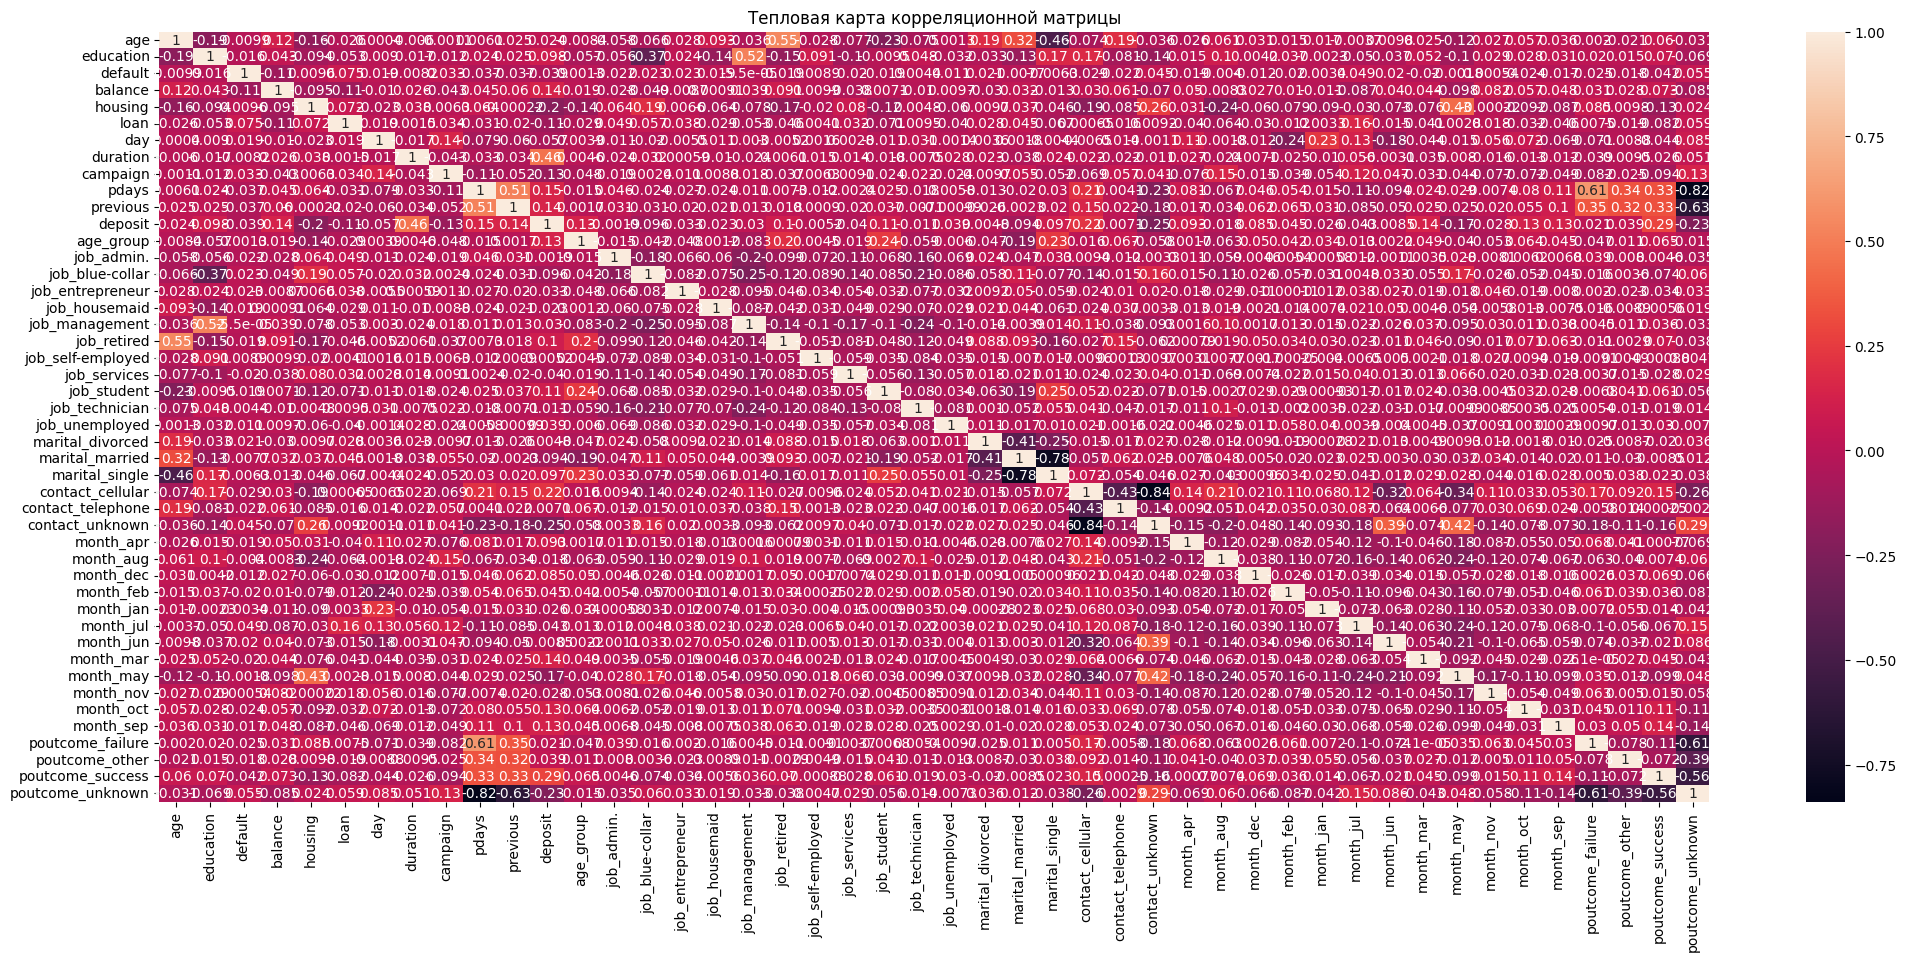

In [50]:
# Строим тепловую карту
plt.figure(figsize=(25, 10))
sns.heatmap(cor_matrix, annot=True)
plt.title("Тепловая карта корреляционной матрицы")
plt.show()

Найдем топ-10 пар с наивысшей  абсолютной корреляцией.

In [51]:
# Все значения матрицы, находящиеся на диагонали и выше нее заменяем на NaN
cor_matrix.values[np.triu_indices_from(cor_matrix, 0)] = np.nan
# Сортируем абсолютные значения по убыванию
cor_matrix.abs().unstack().dropna().sort_values(ascending=False)[:10]

contact_cellular  contact_unknown     0.837885
pdays             poutcome_unknown    0.824031
marital_married   marital_single      0.779038
previous          poutcome_unknown    0.628346
pdays             poutcome_failure    0.608719
poutcome_failure  poutcome_unknown    0.606736
poutcome_success  poutcome_unknown    0.555044
age               job_retired         0.545524
education         job_management      0.518735
pdays             previous            0.513708
dtype: float64

Посмотрим на признаки с самой высокой корреляцией с целевой переменной deposit:

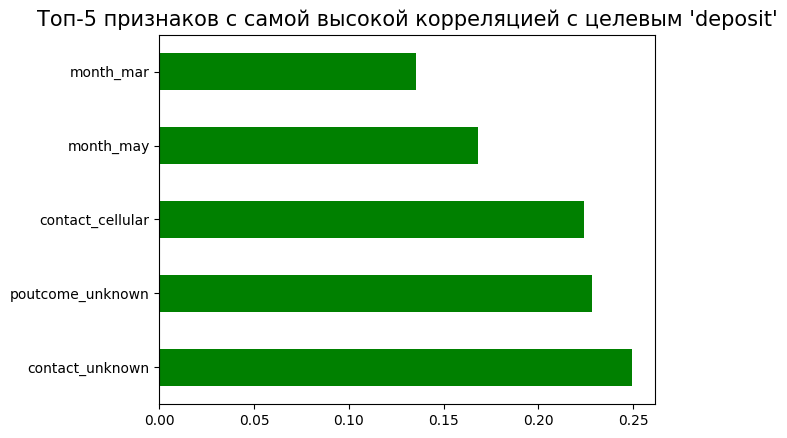

In [52]:
cor_matrix["deposit"].apply(lambda x: abs(x)).sort_values(ascending=False)[1:6].plot.barh(color='green')
plt.title("Топ-5 признаков с самой высокой корреляцией с целевым 'deposit'", fontsize = 15)
plt.show()

### Задания 7 и 8

Теперь определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.

In [53]:
X = df_encoded.drop(['deposit'], axis=1)
y = df_encoded['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [54]:
# рассчитаем необходимые показатели

X_test.shape # размер тестовый выборки
y_test.mean().round(2) # среднее значение целевой переменной

0.46

### Задание 9

С помощью SelectKBest отберем 15 наиболее подходящих признаков

In [55]:
# Инициализируем селектор
selector = SelectKBest(f_classif, k=15)
# Обучаем селектор на трен. выборке
selector.fit(X_train, y_train)
# 15 наиболее важных признака
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

Оставим в наших данных толбко те 15 признаков, которые выбрал селектор SelectorKBest() 

In [56]:
X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

### Задание 10

Нормализуем данные с помощью MinMaxScaler

In [57]:
# Сиздадим нормализатор
scaler = preprocessing.MinMaxScaler()
# Обучим его на треню выборке
scaler.fit(X_train)
# Применим изменения к треню выборке
X_train_scaled = scaler.transform(X_train)
# Применим изменения к тестовой выборке
X_test_scaled = scaler.transform(X_test)

# Посмотрим на средне-арифметическое значение первого столбца
X_test_scaled[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Обучим логистическую регрессию и рассчитаем метрики качества:

In [58]:
# Инициализируем модель
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
# Обучаем модель
log_reg.fit(X_train_scaled, y_train)
# Делаем предсказание на тестовой выборке
y_test_pred = log_reg.predict(X_test_scaled)
# Считаем метрику
f"Метрика accuracy для логистической регрессии: {round(metrics.accuracy_score(y_test, y_test_pred), 2)}"

'Метрика accuracy для логистической регрессии: 0.81'

### Задания 2,3,4

Обучим решающее дерево, найдем  оптимальную максимальную глубину эмпирическим путем:

In [78]:
# Инициализируем модель, дерево решений, оптимальная глубина, получилась - 6
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
# Обучаем модель
dt.fit(X_train_scaled, y_train)
# Делаем предсказание на тестовой выборке
y_dt_pred = dt.predict(X_test_scaled)
# Делаем предсказание на тренировочной выборке
y_dt_pred_train = dt.predict(X_train_scaled)
# Считаем метрики для тренировочной выборки
print("Метрики для тренировочной выборки:")
print(metrics.classification_report(y_train, y_dt_pred_train))
# Считаем метрики для тестовой выборки
print("Метрики для тестовой выборки:")
print(metrics.classification_report(y_test, y_dt_pred))

Метрики для тренировочной выборки:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.77      0.86      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Метрики для тестовой выборки:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

Подберем оптимальные параметры с помощью gridsearch

In [60]:
# Задаем сетку параметров
param_grid = [{'min_samples_split': [2, 5, 7, 10],
               'max_depth': [3, 5, 7]}]

# Создаем сетку поиска с использованием дерева решений и искомых параметров
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1, cv=10, scoring='f1')

# Подбираем параметры на тренировочной выборке
grid_search.fit(X_train_scaled, y_train)

# Выводим f1-score на тестовой выборке
print("F1-score на тестовой выборке:", metrics.f1_score(y_test, grid_search.predict(X_test_scaled)))

# Выводим f1-score на тренировочной выборке
print("F1-score на тренировочной выборке:", metrics.f1_score(y_train, grid_search.predict(X_train_scaled)))

F1-score на тестовой выборке: 0.8027901077996196
F1-score на тренировочной выборке: 0.8253719655442443


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучим случайный лес

In [61]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100, # кол-во деревьев в лесу
                                           criterion='gini', # критерий рабиения
                                           max_depth=10, # максимальная глубина деревьев
                                           min_samples_leaf=5, # миниальное кол-во объектов, чтобы прекратилось разбиение и сформ. лист
                                           random_state=42) # для воспроизводимости результатов
rf_model.fit(X_train_scaled, y_train)
print("Метрики для тестовой выборки:")
print(metrics.classification_report(y_test, rf_model.predict(X_test_scaled)))

Метрики для тестовой выборки:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Построим ROС-кривую, чтобы визуаально оценить, как изменяется доля истинно положительных результатов в зависимости от доли ложноположительных, для разных порогов классификации.

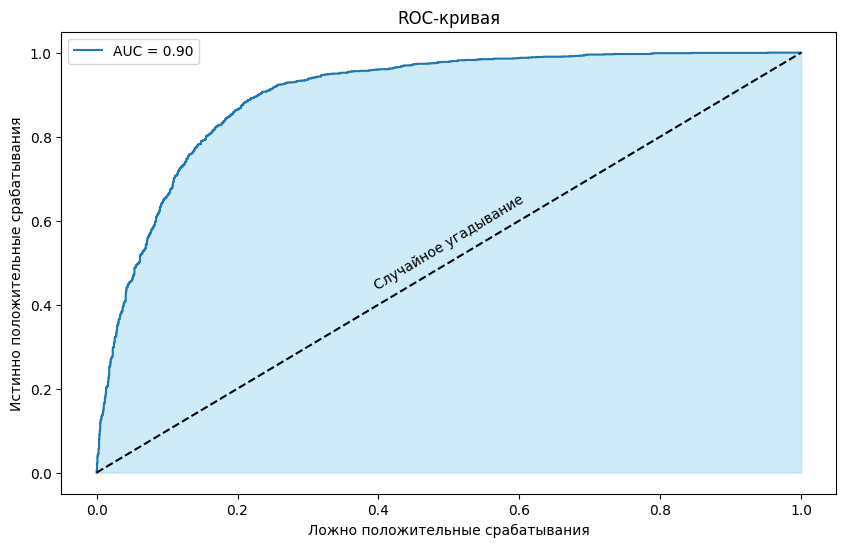

In [62]:
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
auc_score = metrics.roc_auc_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.fill_between(fpr, tpr, color='skyblue', alpha=0.4)
plt.plot([0, 1], [0, 1], 'k--')
plt.text(0.5, 0.55, 'Случайное угадывание', fontsize=10, color='black', ha='center', va='center', rotation=31)
plt.xlabel('Ложно положительные срабатывания')
plt.ylabel('Истинно положительные срабатывания')
plt.title('ROC-кривая')
plt.legend()
plt.show()

ROC-AUC - это метрика, которая показывает общую способность модели различать между положительными и отрицательными классами, в нашем случае метрика получилась 0.9 - это хороший результат, так как результат 1.0 - это идеальная модель, а 0.5 - модель, которая работает не лучше случайного угадывания.

### Задания 2 и 3

Теперь используем градиентный бустинг и сравним его качество со случайным лесом:

In [63]:
gb_model = ensemble.GradientBoostingClassifier(learning_rate=0.5, # темп обучения
                                               n_estimators=300, # кол-во деревьев
                                               min_samples_leaf=5, # минимальное кол-во объектов в листе
                                               max_depth=5, # максимальная глубина деревьев
                                               random_state=42)
gb_model.fit(X_train_scaled, y_train)
print("Метрики для тестовой выборки:")
print(metrics.classification_report(y_test, gb_model.predict(X_test_scaled)))
print("Метрики для тренировочной выборки:")
print(metrics.classification_report(y_train, gb_model.predict(X_train_scaled)))


Метрики для тестовой выборки:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1790
           1       0.78      0.79      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Метрики для тренировочной выборки:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



Видим, что случайный лес справился лучше, в модели градиентного бустинга наблюдается переобучение.

Попробуем подобрать оптимальные гиперпараметры с помощбю Optuna:

In [64]:
def optuna_gb(trial):
    # пространство поиска
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаем модель
    model = ensemble.GradientBoostingClassifier(learning_rate=learning_rate,
                                                n_estimators=n_estimators,
                                                max_depth=max_depth,
                                                min_samples_leaf=min_samples_leaf,
                                                random_state=42)
    
    # Обучим модель с помощью кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='f1', n_jobs=-1).mean()
    return score

In [65]:
# cоздаем объект исследования
study_gb = optuna.create_study(study_name='GradientBoostingClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров
study_gb.optimize(optuna_gb, n_trials=40)

[I 2024-11-08 18:43:35,716] A new study created in memory with name: GradientBoostingClassifier
[I 2024-11-08 18:44:22,237] Trial 0 finished with value: 0.8007037617618844 and parameters: {'n_estimators': 178, 'learning_rate': 0.33510467178409664, 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8007037617618844.
[I 2024-11-08 18:44:58,815] Trial 1 finished with value: 0.7955680287690823 and parameters: {'n_estimators': 141, 'learning_rate': 0.43741539747628844, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8007037617618844.
[I 2024-11-08 18:45:27,091] Trial 2 finished with value: 0.807009422766299 and parameters: {'n_estimators': 128, 'learning_rate': 0.02545134835509647, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.807009422766299.
[I 2024-11-08 18:45:55,609] Trial 3 finished with value: 0.8020129581898164 and parameters: {'n_estimators': 123, 'learning_rate': 0.34265483537196884, 'max_depth': 14, 'min_samples_l

In [66]:
# Результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров: {study_gb.best_params}')
print(f'f1_score на обучающем наборе: {study_gb.best_value}')

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'learning_rate': 0.012682011943965121, 'max_depth': 12, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.812498880274602


In [67]:
# рассчитаем точность для тестовой выборки
model_gb = ensemble.GradientBoostingClassifier(**study_gb.best_params, random_state=42)
model_gb.fit(X_train_scaled, y_train)
print("Метрики для тестовой выборки")
print(metrics.classification_report(y_test, model_gb.predict(X_test_scaled)))


Метрики для тестовой выборки
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Подобрав гиперпараметры, нам удалось предотвратить переобучение, и немного улучшить метрики на тестовой выборке.

### Задание 4

Объединим предыдущие алгоритмы (решающие деревья, логистическую регрессию и градиентный бустинг) с помощью стекинга 

In [68]:
# Создаем список из кортежей (имя модели, сама модель)
estimators = [('dt', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),
              ('log_reg', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)),
              ('gb', ensemble.GradientBoostingClassifier(learning_rate=0.5, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))]

# создаем объект стэкинг
stacking = ensemble.StackingClassifier(estimators,
                                       final_estimator=linear_model.LogisticRegression(random_state=42),
                                       n_jobs=-1)

# Обучаем стэкинг нп трен. выборке
stacking.fit(X_train_scaled, y_train)

# Считаем метрики
print("Метрики для тестовой выборки:")
print(metrics.classification_report(y_test, stacking.predict(X_test_scaled)))


Метрики для тестовой выборки:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

Давайте оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

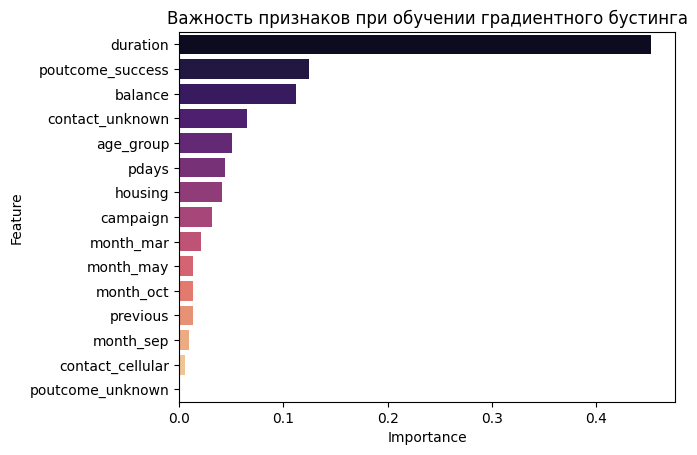

In [69]:
# Создадим датафрейм для удобства визуализации
feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                    'Importance': model_gb.feature_importances_})
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False),
            y='Feature',
            x='Importance',
            palette='magma')
plt.title("Важность признаков при обучении градиентного бустинга")
plt.show()

Как можно понять из графика, наибольший вклад, в обучении модели, вносит признак продолжительность контакта в секундах.

### Задания 6,7,8

Реализуем оптимизацию гиперпараметров случайного леса с помощью библиотеки Optuna

In [70]:
# Создаем целевую функцию
def optuna_rf(trial):
    # Пространство поиска
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            criterion=criterion,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    # Обучим модель на кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='f1', n_jobs=-1).mean()
    return score    

In [71]:
# Создадим объект исследования
studyRF = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# Поиск лучшей комбинации гиперпараметров
studyRF.optimize(optuna_rf, n_trials=30, n_jobs=-1)

[I 2024-11-08 19:04:53,449] A new study created in memory with name: RandomForestClassifier
[I 2024-11-08 19:05:07,889] Trial 0 finished with value: 0.826677370649767 and parameters: {'n_estimators': 200, 'criterion': 'log_loss', 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.826677370649767.
[I 2024-11-08 19:05:08,022] Trial 3 finished with value: 0.8242849519433257 and parameters: {'n_estimators': 196, 'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.826677370649767.
[I 2024-11-08 19:05:08,988] Trial 1 finished with value: 0.8264249267813334 and parameters: {'n_estimators': 113, 'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.826677370649767.
[I 2024-11-08 19:05:09,112] Trial 2 finished with value: 0.8243263380058361 and parameters: {'n_estimators': 136, 'criterion': 'gini', 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.826677370649767.
[I 2024-11

Посмотрим на результаты оптимизации на обучающей выборке:

In [72]:
print(f'Наилучшие значения гиперпараметров: {studyRF.best_params}')
print(f'f1_score на обучающем наборе: {studyRF.best_value}')

Наилучшие значения гиперпараметров: {'n_estimators': 167, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.8284332566649827


Рассчитаем точность для тестовой выборки

In [ ]:
model_rf_best = ensemble.RandomForestClassifier(**studyRF.best_params, random_state=42)
# Обучаем модель
model_rf_best.fit(X_train_scaled, y_train)
# Рассчитаем метрику
f'Метрика F1 для случайного леса на тестовой выборке: {metrics.f1_score(y_test, model_rf_best.predict(X_test_scaled))}'

'Метрика для случайного леса на тестовой выборке: 0.8185840707964602'

Попробуем продолжить подбор параметров:

In [74]:
studyRF.optimize(optuna_rf, n_trials=20)

[I 2024-11-08 19:07:08,443] Trial 30 finished with value: 0.8277592787424484 and parameters: {'n_estimators': 147, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.8284332566649827.
[I 2024-11-08 19:07:15,385] Trial 31 finished with value: 0.8262345293707254 and parameters: {'n_estimators': 174, 'criterion': 'log_loss', 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.8284332566649827.
[I 2024-11-08 19:07:23,070] Trial 32 finished with value: 0.8276139435193883 and parameters: {'n_estimators': 195, 'criterion': 'log_loss', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.8284332566649827.
[I 2024-11-08 19:07:29,024] Trial 33 finished with value: 0.8266163171600669 and parameters: {'n_estimators': 179, 'criterion': 'log_loss', 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.8284332566649827.
[I 2024-11-08 19:07:35,368] Trial 34 finished with value: 0.8281427287147272 and 

In [75]:
print(f'Наилучшие значения гиперпараметров: {studyRF.best_params}')
print(f'f1_score на обучающем наборе: {studyRF.best_value}')

Наилучшие значения гиперпараметров: {'n_estimators': 182, 'criterion': 'log_loss', 'max_depth': 13, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.8287956910153838


In [76]:
model_rf_best = ensemble.RandomForestClassifier(**studyRF.best_params, random_state=42)
# Обучаем модель
model_rf_best.fit(X_train_scaled, y_train)
# Рассчитаем метрику
print(f'Метрика F1 для случайного леса на тестовой выборке: {metrics.f1_score(y_test, model_rf_best.predict(X_test_scaled))}')
print(f'Accuracy для случайного леса на тестовой выборке: {metrics.accuracy_score(y_test, model_rf_best.predict(X_test_scaled))}')

Метрика F1 для случайного леса на тестовой выборке: 0.8199112238427394
Accuracy для случайного леса на тестовой выборке: 0.8296851574212893


С помощью фреймворка Optuna, нам удалось улучшить целевую метрику.

**Вывод:** 

   Попробовали разные алгоритмы для классификации, лучше всех показал себя RandomForestClassifier, так как данные для модели простые(мы их очистили, закодировали, нормализовали, отобрали только важные признаки) и сбалансированные. Так же попытались подбирать гиперпараметры, для максимизации целевой метрики, это дало хоть и не большой, но прирост в качестве модели.